## Seminar Deep Learning (Code for GBP/USD)
Projekt: Predicting Trading Outcomes Using Neural Networks and Random Forest Models

Tobias Winke (593727)

In [ ]:
# Step 1: Load & Format Dataset
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import pandas_ta as pta

### Import of dataset

In [61]:
# Import data
data = pd.read_excel('/Users/tobi/Documents/Projekt Seminar/GBPUSD_H1_clean.xlsx', header=None)

# Manual column names
column_names = ["Gmt time", "Open", "High", "Low", "Close", "Volume"]
data.columns = column_names

# Set the rigt data type
data['Gmt time'] = pd.to_datetime(data['Gmt time'], format='%Y-%m-%d %H:%M')

# Filter: High != Low
data = data[data['High'] != data['Low']]

#Set the index
data.reset_index(drop=True, inplace=True)

# Print data and shape
print(data.head())
print(data.shape)

             Gmt time     Open     High      Low    Close  Volume
0 2008-12-24 00:00:00  1.47235  1.47520  1.47165  1.47380     592
1 2008-12-24 01:00:00  1.47380  1.47550  1.47270  1.47385    1222
2 2008-12-24 02:00:00  1.47385  1.47680  1.47340  1.47635    2238
3 2008-12-24 03:00:00  1.47625  1.47950  1.47597  1.47816    2107
4 2008-12-24 04:00:00  1.47850  1.47885  1.47690  1.47720    2392
(98314, 6)


### Feature Engineering

In [62]:
# Create 'Day' for grouping by days
data['Day'] = data["Gmt time"].dt.date


# Calculate the daily high for each day
daily_high = data.groupby('Day')['High'].max()

# Add the daily high as a new column, shifted by one day (so the previous day)
data['Prev_Daily_High'] = data['Day'].map(daily_high.shift(1))

# Feature engineering: Add variables that check if the closing price is above or below the previous day's high
data['Below_Prev_Daily_High'] = data['Close'] < data['Prev_Daily_High']
data['Above_Prev_Daily_High'] = data['Close'] > data['Prev_Daily_High']

# Check the first few rows
print(data[['High', 'Prev_Daily_High', 'Below_Prev_Daily_High', 'Above_Prev_Daily_High']].head(20))

# Calculate the daily low for each day
daily_low = data.groupby('Day')['Low'].min()

# Add the daily low as a new column, shifted by one day (so the previous day)
data['Prev_Daily_Low'] = data['Day'].map(daily_low.shift(1))

# Feature engineering: Add variables that check if the closing price is above or below the previous day's low
data['Below_Prev_Daily_Low'] = data['Close'] < data['Prev_Daily_Low']
data['Above_Prev_Daily_Low'] = data['Close'] > data['Prev_Daily_Low']

# Check the first few rows
print(data[['Day', 'Low', 'Prev_Daily_Low', 'Below_Prev_Daily_Low', 'Above_Prev_Daily_Low']].head(20))

       High  Prev_Daily_High  Below_Prev_Daily_High  Above_Prev_Daily_High
0   1.47520              NaN                  False                  False
1   1.47550              NaN                  False                  False
2   1.47680              NaN                  False                  False
3   1.47950              NaN                  False                  False
4   1.47885              NaN                  False                  False
5   1.47815              NaN                  False                  False
6   1.47820              NaN                  False                  False
7   1.48045              NaN                  False                  False
8   1.47955              NaN                  False                  False
9   1.47930              NaN                  False                  False
10  1.47890              NaN                  False                  False
11  1.47780              NaN                  False                  False
12  1.47805              

In [63]:
def assign_session(hour):
    if 22 <= hour or hour < 7:
        return 1  # Asia
    elif 7 <= hour < 16:
        return 2  # London
    elif 16 <= hour <= 21:
        return 3  # New York
    else:
        return np.nan  # If there is an error

# Add a new column 'Session' to the data
data['Session'] = data['Gmt time'].dt.hour.apply(assign_session)

# Check the first few rows
print(data[['Gmt time', 'Session']].head(20))


              Gmt time  Session
0  2008-12-24 00:00:00        1
1  2008-12-24 01:00:00        1
2  2008-12-24 02:00:00        1
3  2008-12-24 03:00:00        1
4  2008-12-24 04:00:00        1
5  2008-12-24 05:00:00        1
6  2008-12-24 06:00:00        1
7  2008-12-24 07:00:00        2
8  2008-12-24 08:00:00        2
9  2008-12-24 09:00:00        2
10 2008-12-24 10:00:00        2
11 2008-12-24 11:00:00        2
12 2008-12-24 12:00:00        2
13 2008-12-24 13:00:00        2
14 2008-12-24 14:00:00        2
15 2008-12-24 15:00:00        2
16 2008-12-24 16:00:00        3
17 2008-12-24 17:00:00        3
18 2008-12-24 18:00:00        3
19 2008-12-24 19:00:00        3


### Feature Engineering: Technical Indicators

In [64]:
# Exponential Moving Averages (EMA)
data["EMA_slow"] = pta.ema(data["Close"], length=50)
data["EMA_fast"] = pta.ema(data["Close"], length=20)

# Average True Range
data["ATR"] = pta.atr(data["High"], data["Low"], data["Close"], length=14)

# Relative Strength Index
data["RSI"] = pta.rsi(data["Close"], length=14)

# MACD (with fast=12, slow=26, signal=9 ´default values)
macd = pta.macd(data["Close"], fast=12, slow=26, signal=9)

# Add the MACD values to the data
data["MACD"] = macd["MACD_12_26_9"]
data["MACD_signal"] = macd["MACDs_12_26_9"]
data["MACD_hist"] = macd["MACDh_12_26_9"]

# Reset the index
data.reset_index(inplace=True, drop=True)

In [65]:
#Check the data columns
data.columns

Index(['Gmt time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Day',
       'Prev_Daily_High', 'Below_Prev_Daily_High', 'Above_Prev_Daily_High',
       'Prev_Daily_Low', 'Below_Prev_Daily_Low', 'Above_Prev_Daily_Low',
       'Session', 'EMA_slow', 'EMA_fast', 'ATR', 'RSI', 'MACD', 'MACD_signal',
       'MACD_hist'],
      dtype='object')

### Create Target Variable

In [66]:
def create_multiclass_labels(data, max_horizon=24, sl_coef=1.5, tp_coef=3.0):
    
    labels = []
    n = len(data)

    for i in range(n):
        # ================
        # 1) Initial data
        # ================
        entry_price = data.loc[i, 'Close']
        if pd.isna(entry_price):
            # If no price available, no trade possible
            labels.append(0)
            continue

        # Long-Trade SL/TP
        sl_long = entry_price - sl_coef * data.loc[i, 'ATR']
        tp_long = entry_price + tp_coef * data.loc[i, 'ATR']

        # Short-Trade SL/TP
        sl_short = entry_price + sl_coef * data.loc[i, 'ATR']
        tp_short = entry_price - tp_coef * data.loc[i, 'ATR']

        # Flags, if Long/Short are still "open" (SL/TP not reached)
        long_open = True
        short_open = True

        # Flags, if Long/Short won
        long_won = False
        short_won = False

        label_i = 0  # default = 0

        # =======================================
        # 2) Check the next max_horizon candles
        # =======================================
        upper_bound = min(i + max_horizon, n - 1)  # Index cannot drop out of the dataframe

        for j in range(i + 1, upper_bound + 1):
            high_j = data.loc[j, 'High']
            low_j  = data.loc[j, 'Low']

            # -- Long-Trade Check --
            if long_open:
                # a) Stop-Loss hit?
                if low_j <= sl_long:
                    # Long-Trade loses -> not profitable
                    long_open = False
                # b) Take-Profit hit?
                elif high_j >= tp_long:
                    # Long-Trade wins, we get Label=2, 
                    long_won = True
                    label_i = 2
                    # If Long wins, we end the loop,
                    # BUT we have to check if Short already hit TP before. 
                    # According to the rule:
                    # "If the TP of one direction is reached first,
                    #  then this direction counts." 
                    #  => We break the loop
                    #   
                    break

            # -- Short-Trade Check --
            if short_open:
                # a) Stop-Loss hit?
                if high_j >= sl_short:
                    # Short-Trade loses -> not profitable
                    short_open = False
                # b) Take-Profit hit?
                elif low_j <= tp_short:
                    # Short-Trade wins, we get Label=1
                    short_won = True
                    label_i = 1
                    # Here, as well, we break the loop.
                    break

        # End of the loop if no TP reached
        # => label_i stays 0
        labels.append(label_i)

    # New column 'Label' in the dataframe
    data['Label'] = labels
    return data



In [67]:
#Apply the function to the data and check the first 50 rows
data = create_multiclass_labels(data, max_horizon=24, sl_coef=1.5, tp_coef=3.0)
data[['Close','ATR','Label']].head(50)

,Close,ATR,Label
0,1.47380,NaN,0
1,1.47385,NaN,0
2,1.47635,NaN,0
3,1.47816,NaN,0
4,1.47720,NaN,0
5,1.47775,NaN,0
6,1.47710,NaN,0
7,1.47895,NaN,0
8,1.47835,NaN,0
9,1.47235,NaN,0


In [68]:
data = data.dropna()

In [69]:
print(data.shape)

(98264, 22)


## Random Forest Model

In [70]:
import copy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Convert 'Gmt time' to datetime and sort the data
data['Gmt time'] = pd.to_datetime(data['Gmt time'])
data.sort_values('Gmt time', inplace=True)

# Define features (X) and label (y)
feature_cols = [
    'Volume', 'Prev_Daily_High', 'Below_Prev_Daily_High', 
    'Above_Prev_Daily_High', 'Prev_Daily_Low', 'Below_Prev_Daily_Low', 
    'Above_Prev_Daily_Low', 'Session', 'EMA_slow', 'EMA_fast', 
    'ATR', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist'
]
X_full = data[feature_cols]
y_full = data['Label']

# Rolling time window settings: 3 months training, 1 month testing
train_window = pd.DateOffset(months=3)
test_window = pd.DateOffset(months=1)

# Initialize storage for evaluation results, models, and predictions
rf_results = []
rf_trained_models = []  # Will store the trained RF model for each window
rf_predictions_list = []  # Will store the predictions for each test window

# Define rolling windows based on 'Gmt time'
start_date = data['Gmt time'].min()
end_date = data['Gmt time'].max()
train_start = start_date

while train_start + train_window + test_window <= end_date:
    train_end = train_start + train_window
    test_start = train_end
    test_end = test_start + test_window

    # Slice the data based on 'Gmt time'
    train_df = data[(data['Gmt time'] >= train_start) & (data['Gmt time'] < train_end)]
    test_df  = data[(data['Gmt time'] >= test_start) & (data['Gmt time'] < test_end)]

    X_train, y_train = train_df[feature_cols], train_df['Label']
    X_test, y_test   = test_df[feature_cols], test_df['Label']

    # Define and train the Random Forest model
    rf_params = {
        'n_estimators': 100,
        'max_depth': 5,
        'min_samples_leaf': 6,
        'min_samples_split': 15,
        'random_state': 42,
        'criterion': 'entropy',
        'max_features': 'sqrt',
    }
    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_train, y_train)

    # Generate predictions on the test set
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    class_report = classification_report(y_test, y_pred, zero_division=0)

    # Store evaluation results
    rf_results.append({
        'Train Period': f"{train_start.date()} to {train_end.date()}",
        'Test Period': f"{test_start.date()} to {test_end.date()}",
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Classification Report': class_report
    })

    # Save the trained RF model for this window
    rf_trained_models.append({
        'Train Period': f"{train_start.date()} to {train_end.date()}",
        'Model': copy.deepcopy(rf)
    })

    # Save predictions along with the corresponding 'Gmt time'
    pred_df = pd.DataFrame({
        'Gmt time': test_df['Gmt time'].values,
        'Label_pred': y_pred
    })
    rf_predictions_list.append(pred_df)

    # Move the rolling window forward by one month
    train_start = train_start + test_window

# (Optional) Print the evaluation results
for res in rf_results:
    print("=" * 50)
    print(f"Train: {res['Train Period']} | Test: {res['Test Period']}")
    print(f"Accuracy:  {res['Accuracy']:.3f}")
    print(f"Precision: {res['Precision']:.3f}")
    print(f"Recall:    {res['Recall']:.3f}")
    print(f"F1-Score:  {res['F1-Score']:.3f}")
    print("Classification Report:\n", res['Classification Report'])

# Combine all RF predictions into one DataFrame (sorted by time)
rf_predictions_full = pd.concat(rf_predictions_list, ignore_index=True)
rf_predictions_full.sort_values('Gmt time', inplace=True)


Train: 2008-12-26 to 2009-03-26 | Test: 2009-03-26 to 2009-04-26
Accuracy:  0.370
Precision: 0.389
Recall:    0.322
F1-Score:  0.298
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.52      0.48       256
           1       0.25      0.39      0.31       131
           2       0.47      0.06      0.11       129

    accuracy                           0.37       516
   macro avg       0.39      0.32      0.30       516
weighted avg       0.40      0.37      0.34       516

Train: 2009-01-26 to 2009-04-26 | Test: 2009-04-26 to 2009-05-26
Accuracy:  0.333
Precision: 0.266
Recall:    0.436
F1-Score:  0.239
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.41      0.51       314
           1       0.12      0.90      0.20        39
           2       0.00      0.00      0.00       140

    accuracy                           0.33       493
   macro avg       0.27      0.44

### LaTeX Table of RF Results

In [71]:
# --- Helper function to extract support counts for each class from the classification report ---
def extract_support_counts(report):
    """
    Parses the classification report and returns a dictionary with the support counts for each class.
    It assumes that lines starting with a digit correspond to class entries and that the support is the last token.
    """
    counts = {}
    lines = report.splitlines()
    for line in lines:
        line = line.strip()
        if not line:
            continue
        tokens = line.split()
        # Check if the line starts with a digit and has at least 5 tokens (class, precision, recall, f1, support)
        if tokens and tokens[0].isdigit() and len(tokens) >= 5:
            class_label = tokens[0]
            try:
                support = int(tokens[-1])
            except ValueError:
                support = 0
            counts[class_label] = support
    return counts

# --- Process the results list to add support counts for each class ---
results_with_support = []
for res in rf_results:
    support_counts = extract_support_counts(res['Classification Report'])
    new_res = {
        'Train Period': res['Train Period'],
        'Test Period': res['Test Period'],
        'Accuracy': res['Accuracy'],
        'Precision': res['Precision'],
        'Recall': res['Recall'],
        'F1-Score': res['F1-Score'],
        'Class 0': support_counts.get('0', 0),
        'Class 1': support_counts.get('1', 0),
        'Class 2': support_counts.get('2', 0)
    }
    results_with_support.append(new_res)

# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(results_with_support)

# Optionally, reorder columns if needed
results_df = results_df[['Train Period', 'Test Period', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 
                           'Class 0', 'Class 1', 'Class 2']]

# Convert the DataFrame to a LaTeX table.
latex_table = results_df.to_latex(
    index=False,
    caption="Random Forest Performance over Rolling Windows",
    label="tab:rf_results",
    float_format="%.3f"
)

# Optionally, write the LaTeX table to a file.
with open("rf_results_table.tex", "w") as f:
    f.write(latex_table)

# Print the LaTeX table code for inclusion in your document.
print(latex_table)


\begin{table}
\caption{Random Forest Performance over Rolling Windows}
\label{tab:rf_results}
\begin{tabular}{llrrrrrrr}
\toprule
Train Period & Test Period & Accuracy & Precision & Recall & F1-Score & Class 0 & Class 1 & Class 2 \\
\midrule
2008-12-26 to 2009-03-26 & 2009-03-26 to 2009-04-26 & 0.370 & 0.389 & 0.322 & 0.298 & 256 & 131 & 129 \\
2009-01-26 to 2009-04-26 & 2009-04-26 to 2009-05-26 & 0.333 & 0.266 & 0.436 & 0.239 & 314 & 39 & 140 \\
2009-02-26 to 2009-05-26 & 2009-05-26 to 2009-06-26 & 0.343 & 0.144 & 0.336 & 0.177 & 183 & 146 & 207 \\
2009-03-26 to 2009-06-26 & 2009-06-26 to 2009-07-26 & 0.395 & 0.514 & 0.427 & 0.391 & 209 & 145 & 132 \\
2009-04-26 to 2009-07-26 & 2009-07-26 to 2009-08-26 & 0.379 & 0.456 & 0.376 & 0.356 & 235 & 152 & 125 \\
2009-05-26 to 2009-08-26 & 2009-08-26 to 2009-09-26 & 0.392 & 0.367 & 0.375 & 0.355 & 235 & 147 & 154 \\
2009-06-26 to 2009-09-26 & 2009-09-26 to 2009-10-26 & 0.393 & 0.406 & 0.407 & 0.362 & 224 & 96 & 146 \\
2009-07-26 to 2009-10-26 

In [106]:
numeric_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Compute summary statistics including the 25% and 75% quantiles.
stats = results_df[numeric_cols].agg([
    'min',
    lambda x: x.quantile(0.25),
    'mean',
    'median',
    lambda x: x.quantile(0.75),
    'max'
])

# Rename the lambda rows for clarity.
stats.index = ['min', '25%', 'mean', 'median', '75%', 'max']

# Print the statistics
print(stats)

# Convert these statistics to a LaTeX table.
stats_latex = stats.to_latex(
    caption="Summary Statistics for RF Performance over Rolling Windows",
    label="tab:rf_stats_GU",
    float_format="%.3f"
)
print(stats_latex)

# Optionally, write the LaTeX table to a file.
with open("RF_summary_stats.tex", "w") as f:
    f.write(stats_latex)


        Accuracy  Precision    Recall  F1-Score
min     0.190019   0.064202  0.241674  0.107667
25%     0.340816   0.248054  0.328675  0.234986
mean    0.385279   0.322652  0.354181  0.280850
median  0.385659   0.324082  0.348566  0.285462
75%     0.435897   0.386523  0.378833  0.323884
max     0.576108   0.693265  0.466993  0.464729
\begin{table}
\caption{Summary Statistics for RF Performance over Rolling Windows}
\label{tab:rf_stats_GU}
\begin{tabular}{lrrrr}
\toprule
 & Accuracy & Precision & Recall & F1-Score \\
\midrule
min & 0.190 & 0.064 & 0.242 & 0.108 \\
25% & 0.341 & 0.248 & 0.329 & 0.235 \\
mean & 0.385 & 0.323 & 0.354 & 0.281 \\
median & 0.386 & 0.324 & 0.349 & 0.285 \\
75% & 0.436 & 0.387 & 0.379 & 0.324 \\
max & 0.576 & 0.693 & 0.467 & 0.465 \\
\bottomrule
\end{tabular}
\end{table}



### Visualization of RF Performance Metrics

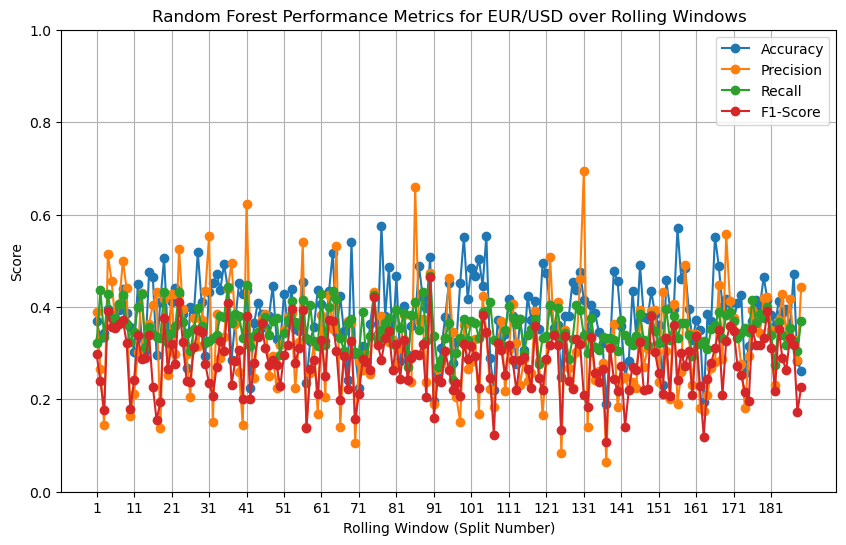

In [72]:
# Convert 'rf_results' (a list of dicts) into a pandas DataFrame.
df_results = pd.DataFrame(rf_results)

# Create a new column 'Split' to index each rolling window.
df_results['Split'] = range(1, len(df_results) + 1)

# Define the metrics you want to plot.
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Set up the plot.
plt.figure(figsize=(10, 6))

# Plot each metric across the splits.
for metric in metrics:
    plt.plot(df_results['Split'], df_results[metric], marker='o', label=metric)

plt.title("Random Forest Performance Metrics for EUR/USD over Rolling Windows")
plt.xlabel("Rolling Window (Split Number)")
plt.ylabel("Score")
plt.ylim(0.0, 1.0)  # scores are between 0 and 1

# Set x-ticks in steps of 10.
plt.xticks(range(1, len(df_results) + 1, 10))

plt.grid(True)
plt.legend()
plt.show()

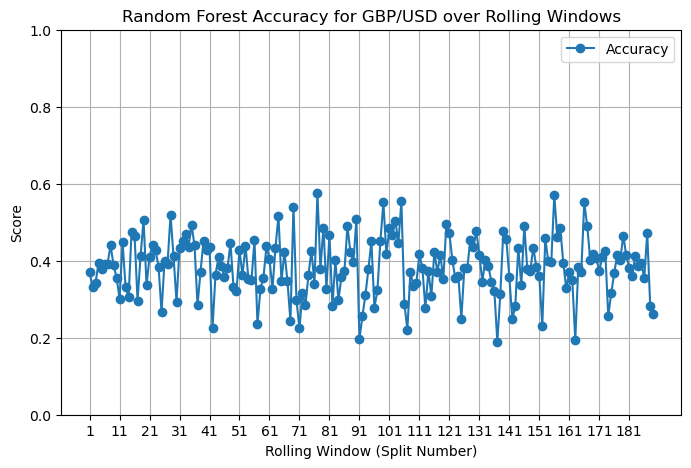

In [73]:
#Plot for Random Forest Accuracy
metric_to_plot = "Accuracy"  
color_choice = "#1f77b4"        

plt.figure(figsize=(8, 5))
plt.plot(df_results['Split'], df_results[metric_to_plot], marker='o', color=color_choice, label=metric_to_plot)

plt.title("Random Forest " + metric_to_plot + " for GBP/USD over Rolling Windows")
plt.xlabel("Rolling Window (Split Number)")
plt.ylabel("Score")
plt.ylim(0.0, 1.0)  # scores are between 0 and 1

# Set x-ticks in steps of 10.
plt.xticks(range(1, len(df_results) + 1, 10))

plt.grid(True)
plt.legend()
plt.show()


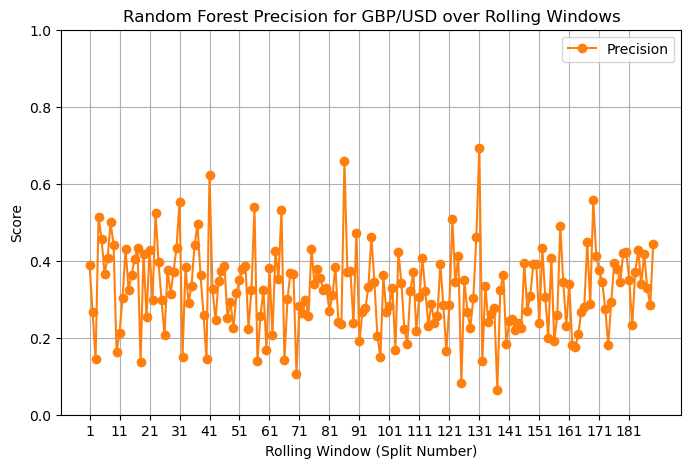

In [74]:
#Plot for Random Forest Precision
metric_to_plot = "Precision"  
color_choice = "#ff7f0e"        

plt.figure(figsize=(8, 5))
plt.plot(df_results['Split'], df_results[metric_to_plot], marker='o', color=color_choice, label=metric_to_plot)

plt.title("Random Forest " + metric_to_plot + " for GBP/USD over Rolling Windows")
plt.xlabel("Rolling Window (Split Number)")
plt.ylabel("Score")
plt.ylim(0.0, 1.0)  # scores are between 0 and 1

# Set x-ticks in steps of 10.
plt.xticks(range(1, len(df_results) + 1, 10))

plt.grid(True)
plt.legend()
plt.show()

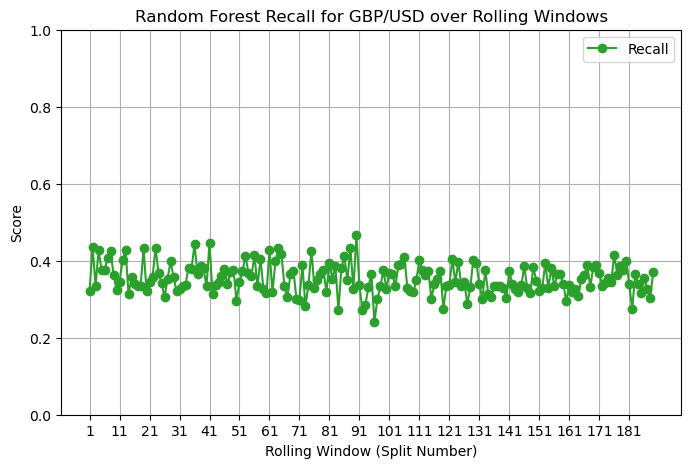

In [75]:
#Plot for Random Forest Recall
metric_to_plot = "Recall"  
color_choice = "#2ca02c"        

plt.figure(figsize=(8, 5))
plt.plot(df_results['Split'], df_results[metric_to_plot], marker='o', color=color_choice, label=metric_to_plot)

plt.title("Random Forest " + metric_to_plot + " for GBP/USD over Rolling Windows")
plt.xlabel("Rolling Window (Split Number)")
plt.ylabel("Score")
plt.ylim(0.0, 1.0)  # scores are between 0 and 1

# Set x-ticks in steps of 10.
plt.xticks(range(1, len(df_results) + 1, 10))

plt.grid(True)
plt.legend()
plt.show()

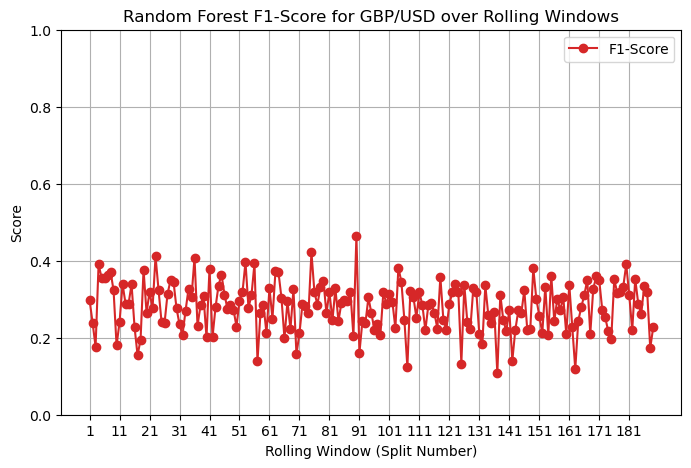

In [76]:
#Plot for Random Forest F1-Score
metric_to_plot = "F1-Score"  
color_choice = "#d62728"        

plt.figure(figsize=(8, 5))
plt.plot(df_results['Split'], df_results[metric_to_plot], marker='o', color=color_choice, label=metric_to_plot)

plt.title("Random Forest " + metric_to_plot + " for GBP/USD over Rolling Windows")
plt.xlabel("Rolling Window (Split Number)")
plt.ylabel("Score")
plt.ylim(0.0, 1.0)  # scores are between 0 and 1

# Set x-ticks in steps of 10.
plt.xticks(range(1, len(df_results) + 1, 10))

plt.grid(True)
plt.legend()
plt.show()

## Neural Network Model: MLP 

APPLIED MLP Parameters:
'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,50), 'mlp__solver': 'adam'

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report



# Convert 'Gmt time' to datetime and sort the data
data['Gmt time'] = pd.to_datetime(data['Gmt time'])
data.sort_values('Gmt time', inplace=True)

# Define features (X) and label (y)
feature_cols = [
    'Volume', 'Prev_Daily_High', 'Below_Prev_Daily_High', 
    'Above_Prev_Daily_High', 'Prev_Daily_Low', 'Below_Prev_Daily_Low', 
    'Above_Prev_Daily_Low', 'Session', 'EMA_slow', 'EMA_fast', 
    'ATR', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist'
]
X_full = data[feature_cols]
y_full = data['Label']

# Rolling time window settings: 3 months training, 1 month testing
train_window = pd.DateOffset(months=3)
test_window = pd.DateOffset(months=1)

# Initialize storage for evaluation results, models, and predictions
mlp_results = []
mlp_trained_models = []  # To store the trained MLP pipeline for each window
mlp_predictions_list = []  # To store the predictions for each test window

# Define rolling windows
start_date = data['Gmt time'].min()
end_date = data['Gmt time'].max()
train_start = start_date

# Create the pipeline using the best parameters from grid search:
# {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,50), 'mlp__solver': 'adam'}
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        max_iter=1000,
        random_state=42,
        activation='relu',
        alpha=0.001,
        hidden_layer_sizes=(50,50),
        solver='adam'
    ))
])

while train_start + train_window + test_window <= end_date:
    train_end = train_start + train_window
    test_start = train_end
    test_end = test_start + test_window

    # Train/Test slicing based on 'Gmt time'
    train_df = data[(data['Gmt time'] >= train_start) & (data['Gmt time'] < train_end)]
    test_df = data[(data['Gmt time'] >= test_start) & (data['Gmt time'] < test_end)]

    X_train, y_train = train_df[feature_cols], train_df['Label']
    X_test, y_test = test_df[feature_cols], test_df['Label']

    # Fit the pipeline on the training data
    mlp_pipeline.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = mlp_pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    class_report = classification_report(y_test, y_pred, zero_division=0)

    # Store results for this rolling window
    mlp_results.append({
        'Train Period': f"{train_start.date()} to {train_end.date()}",
        'Test Period': f"{test_start.date()} to {test_end.date()}",
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Classification Report': class_report
    })

    # Save a deep copy of the trained MLP pipeline for this window
    mlp_trained_models.append({
        'Train Period': f"{train_start.date()} to {train_end.date()}",
        'Model': copy.deepcopy(mlp_pipeline)
    })

    # Save predictions along with the corresponding 'Gmt time'
    pred_df = pd.DataFrame({
        'Gmt time': test_df['Gmt time'].values,
        'Label_pred': y_pred
    })
    mlp_predictions_list.append(pred_df)

    # Move the rolling window forward by one month
    train_start = train_start + test_window

# Print the MLP parameters
print("=" * 50)
print("MLP PARAMETERS:")
print({'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,50), 'mlp__solver': 'adam'})
print("=" * 50)

# Print the evaluation results for each window
for res in mlp_results:
    print("=" * 50)
    print(f"Train: {res['Train Period']} | Test: {res['Test Period']}")
    print(f"Accuracy:  {res['Accuracy']:.3f}")
    print(f"Precision: {res['Precision']:.3f}")
    print(f"Recall:    {res['Recall']:.3f}")
    print(f"F1-Score:  {res['F1-Score']:.3f}")
    print("Classification Report:\n", res['Classification Report'])

# Combine all MLP predictions into one DataFrame (sorted by 'Gmt time')
mlp_predictions_full = pd.concat(mlp_predictions_list, ignore_index=True)
mlp_predictions_full.sort_values('Gmt time', inplace=True)

MLP PARAMETERS:
{'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__solver': 'adam'}
Train: 2008-12-26 to 2009-03-26 | Test: 2009-03-26 to 2009-04-26
Accuracy:  0.355
Precision: 0.348
Recall:    0.349
F1-Score:  0.344
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.37      0.42       256
           1       0.36      0.40      0.38       131
           2       0.21      0.28      0.24       129

    accuracy                           0.35       516
   macro avg       0.35      0.35      0.34       516
weighted avg       0.38      0.35      0.36       516

Train: 2009-01-26 to 2009-04-26 | Test: 2009-04-26 to 2009-05-26
Accuracy:  0.357
Precision: 0.611
Recall:    0.477
F1-Score:  0.271
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.43      0.53       314
           1       0.13      0.97      0.22        39
           2     

### LaTeX Table of MLP Results

In [78]:
# --- Helper function to extract support counts for each class from the classification report ---
def extract_support_counts(report):
    """
    Parses the classification report and returns a dictionary with the support counts for each class.
    It assumes that lines starting with a digit correspond to class entries and that the support is the last token.
    """
    counts = {}
    lines = report.splitlines()
    for line in lines:
        line = line.strip()
        if not line:
            continue
        tokens = line.split()
        # Check if the line starts with a digit and has at least 5 tokens (class, precision, recall, f1, support)
        if tokens and tokens[0].isdigit() and len(tokens) >= 5:
            class_label = tokens[0]
            try:
                support = int(tokens[-1])
            except ValueError:
                support = 0
            counts[class_label] = support
    return counts

# --- Process the results list to add support counts for each class ---
mlp_results_with_support = []
for res in mlp_results:
    support_counts = extract_support_counts(res['Classification Report'])
    new_res = {
        'Train Period': res['Train Period'],
        'Test Period': res['Test Period'],
        'Accuracy': res['Accuracy'],
        'Precision': res['Precision'],
        'Recall': res['Recall'],
        'F1-Score': res['F1-Score'],
        'Class 0': support_counts.get('0', 0),
        'Class 1': support_counts.get('1', 0),
        'Class 2': support_counts.get('2', 0)
    }
    mlp_results_with_support.append(new_res)

# Convert the list of dictionaries into a DataFrame
mlp_results_df = pd.DataFrame(mlp_results_with_support)

# Optionally, reorder columns if needed
mlp_results_df = mlp_results_df[['Train Period', 'Test Period', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 
                           'Class 0', 'Class 1', 'Class 2']]

# Convert the DataFrame to a LaTeX table.
mlp_latex_table = mlp_results_df.to_latex(
    index=False,
    caption="Neural Network Performance over Rolling Windows",
    label="tab:mlp_results",
    float_format="%.3f"
)

# Optionally, write the LaTeX table to a file.
with open("mlp_results_table.tex", "w") as f:
    f.write(mlp_latex_table)

# Print the LaTeX table code for inclusion in your document.
print(mlp_latex_table)


\begin{table}
\caption{Neural Network Performance over Rolling Windows}
\label{tab:mlp_results}
\begin{tabular}{llrrrrrrr}
\toprule
Train Period & Test Period & Accuracy & Precision & Recall & F1-Score & Class 0 & Class 1 & Class 2 \\
\midrule
2008-12-26 to 2009-03-26 & 2009-03-26 to 2009-04-26 & 0.355 & 0.348 & 0.349 & 0.344 & 256 & 131 & 129 \\
2009-01-26 to 2009-04-26 & 2009-04-26 to 2009-05-26 & 0.357 & 0.611 & 0.477 & 0.271 & 314 & 39 & 140 \\
2009-02-26 to 2009-05-26 & 2009-05-26 to 2009-06-26 & 0.317 & 0.298 & 0.307 & 0.265 & 183 & 146 & 207 \\
2009-03-26 to 2009-06-26 & 2009-06-26 to 2009-07-26 & 0.438 & 0.460 & 0.454 & 0.440 & 209 & 145 & 132 \\
2009-04-26 to 2009-07-26 & 2009-07-26 to 2009-08-26 & 0.400 & 0.415 & 0.399 & 0.388 & 235 & 152 & 125 \\
2009-05-26 to 2009-08-26 & 2009-08-26 to 2009-09-26 & 0.265 & 0.265 & 0.265 & 0.261 & 235 & 147 & 154 \\
2009-06-26 to 2009-09-26 & 2009-09-26 to 2009-10-26 & 0.361 & 0.389 & 0.357 & 0.308 & 224 & 96 & 146 \\
2009-07-26 to 2009-10-2

In [107]:
# Select only the numeric columns from your mlp_results_df
numeric_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Compute summary statistics including the 25% and 75% quantiles.
stats = mlp_results_df[numeric_cols].agg([
    'min',
    lambda x: x.quantile(0.25),
    'mean',
    'median',
    lambda x: x.quantile(0.75),
    'max'
])

# Rename the lambda rows for clarity.
stats.index = ['min', '25%', 'mean', 'median', '75%', 'max']

# Print the statistics
print(stats)

# If you want to convert these statistics to a LaTeX table:
stats_latex = stats.to_latex(
    caption="Summary Statistics for MLP Performance over Rolling Windows",
    label="tab:mlp_stats_GU",
    float_format="%.3f"
)
print(stats_latex)

# Optionally, write the LaTeX table to a file:
with open("mlp_summary_stats.tex", "w") as f:
    f.write(stats_latex)


        Accuracy  Precision    Recall  F1-Score
min     0.212766   0.195563  0.216932  0.192720
25%     0.312377   0.315892  0.329618  0.283242
mean    0.356800   0.362662  0.356526  0.320631
median  0.355086   0.357329  0.354607  0.318495
75%     0.397436   0.402446  0.383380  0.359476
max     0.533719   0.644657  0.562370  0.531463
\begin{table}
\caption{Summary Statistics for MLP Performance over Rolling Windows}
\label{tab:mlp_stats_GU}
\begin{tabular}{lrrrr}
\toprule
 & Accuracy & Precision & Recall & F1-Score \\
\midrule
min & 0.213 & 0.196 & 0.217 & 0.193 \\
25% & 0.312 & 0.316 & 0.330 & 0.283 \\
mean & 0.357 & 0.363 & 0.357 & 0.321 \\
median & 0.355 & 0.357 & 0.355 & 0.318 \\
75% & 0.397 & 0.402 & 0.383 & 0.359 \\
max & 0.534 & 0.645 & 0.562 & 0.531 \\
\bottomrule
\end{tabular}
\end{table}



## Visualization of MLP Performance Metrics

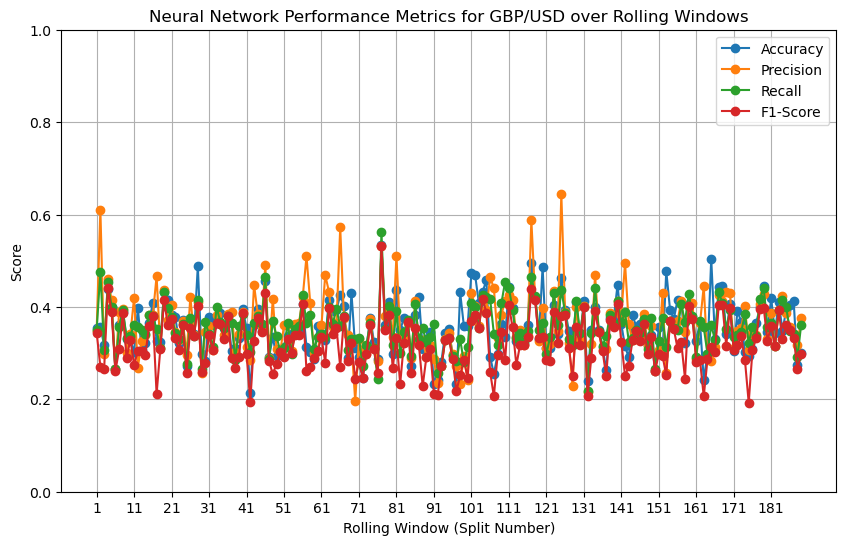

In [79]:
# Convert 'results' (a list of dicts) into a pandas DataFrame.
df_mlp_results = pd.DataFrame(mlp_results)

# Create a new column 'Split' to index each rolling window.
df_mlp_results['Split'] = range(1, len(df_results) + 1)

# Define the metrics you want to plot.
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Set up the plot.
plt.figure(figsize=(10, 6))

# Plot each metric across the splits.
for metric in metrics:
    plt.plot(df_mlp_results['Split'], df_mlp_results[metric], marker='o', label=metric)

plt.title("Neural Network Performance Metrics for GBP/USD over Rolling Windows")
plt.xlabel("Rolling Window (Split Number)")
plt.ylabel("Score")
plt.ylim(0.0, 1.0)  # scores are between 0 and 1

# Set x-ticks in steps of 10.
plt.xticks(range(1, len(df_results) + 1, 10))

plt.grid(True)
plt.legend()
plt.show()

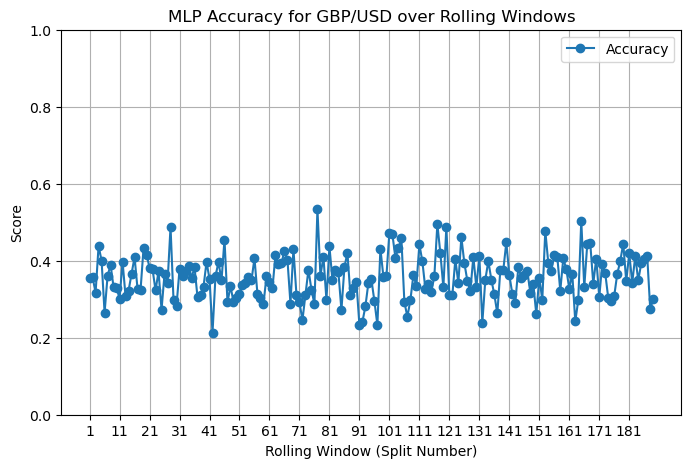

In [92]:
#Plot for Neural Network Accuracy
metric_to_plot = "Accuracy"  
color_choice = "#1f77b4"        

plt.figure(figsize=(8, 5))
plt.plot(df_mlp_results['Split'], df_mlp_results[metric_to_plot], marker='o', color=color_choice, label=metric_to_plot)

plt.title("MLP " + metric_to_plot + " for GBP/USD over Rolling Windows")
plt.xlabel("Rolling Window (Split Number)")
plt.ylabel("Score")
plt.ylim(0.0, 1.0)  # scores are between 0 and 1

# Set x-ticks in steps of 10.
plt.xticks(range(1, len(df_results) + 1, 10))

plt.grid(True)
plt.legend()
plt.show()

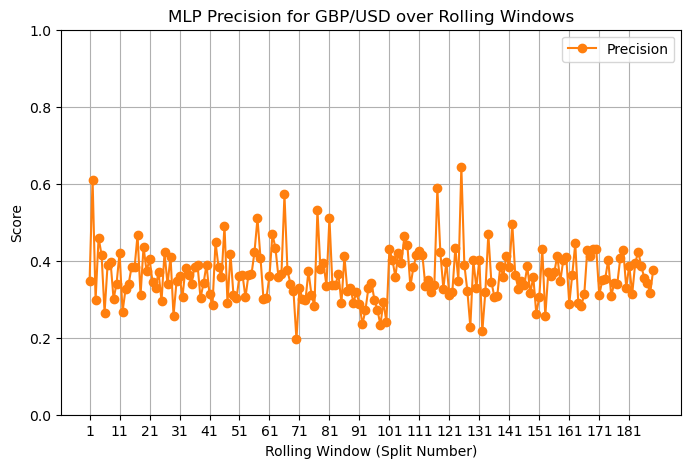

In [93]:
#Plot for Neural Network Precision
metric_to_plot = "Precision"  
color_choice = "#ff7f0e"        

plt.figure(figsize=(8, 5))
plt.plot(df_mlp_results['Split'], df_mlp_results[metric_to_plot], marker='o', color=color_choice, label=metric_to_plot)

plt.title("MLP " + metric_to_plot + " for GBP/USD over Rolling Windows")
plt.xlabel("Rolling Window (Split Number)")
plt.ylabel("Score")
plt.ylim(0.0, 1.0)  # scores are between 0 and 1

# Set x-ticks in steps of 10.
plt.xticks(range(1, len(df_results) + 1, 10))

plt.grid(True)
plt.legend()
plt.show()

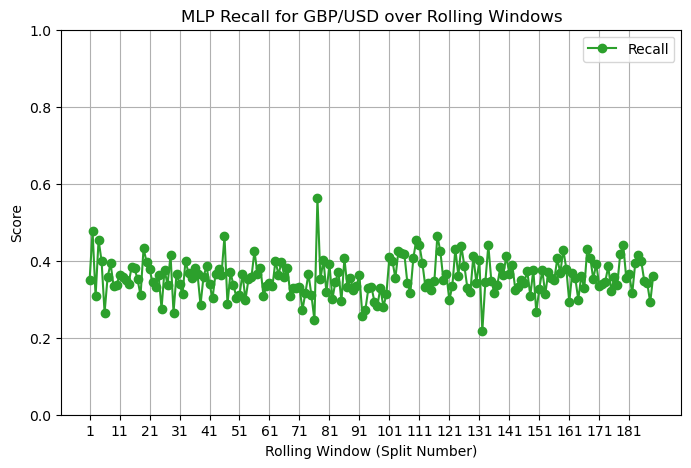

In [94]:
#Plot for Neural Network Recall
metric_to_plot = "Recall"  
color_choice = "#2ca02c"        

plt.figure(figsize=(8, 5))
plt.plot(df_mlp_results['Split'], df_mlp_results[metric_to_plot], marker='o', color=color_choice, label=metric_to_plot)

plt.title("MLP " + metric_to_plot + " for GBP/USD over Rolling Windows")
plt.xlabel("Rolling Window (Split Number)")
plt.ylabel("Score")
plt.ylim(0.0, 1.0)  # scores are between 0 and 1

# Set x-ticks in steps of 10.
plt.xticks(range(1, len(df_results) + 1, 10))

plt.grid(True)
plt.legend()
plt.show()

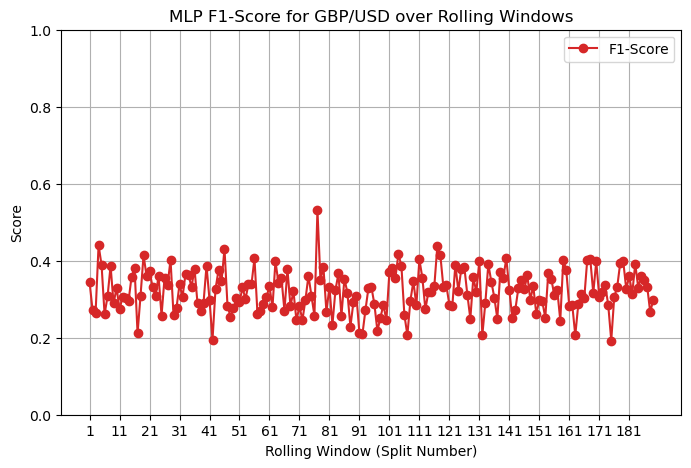

In [95]:
#Plot for Neural Network F1-Score
metric_to_plot = "F1-Score"  
color_choice = "#d62728"        

plt.figure(figsize=(8, 5))
plt.plot(df_mlp_results['Split'], df_mlp_results[metric_to_plot], marker='o', color=color_choice, label=metric_to_plot)

plt.title("MLP " + metric_to_plot + " for GBP/USD over Rolling Windows")
plt.xlabel("Rolling Window (Split Number)")
plt.ylabel("Score")
plt.ylim(0.0, 1.0)  # scores are between 0 and 1

# Set x-ticks in steps of 10.
plt.xticks(range(1, len(df_results) + 1, 10))

plt.grid(True)
plt.legend()
plt.show()

## Backtesting the Model Predictions

## Random Forest: Framework 2  

RF Detailed Metrics:
Total Return (%): -16.62984829558414
Avg Return per Year (%): -1.0393655184740087
Number of Trades: 4222
Long Trades: 1821
Long Win Percentage (%): 35.96924766611752
Short Trades: 2401
Short Win Percentage (%): 36.15160349854227
Yearly Returns (%): {2009: 5.014007220325474, 2010: 19.975978439531875, 2011: 15.985010938243812, 2012: 9.54015286581194, 2013: 22.667968647731453, 2014: -4.090151734099436, 2015: -0.058051505805196656, 2016: -11.5405678760883, 2017: -5.099507811042389, 2018: -47.288639021188125, 2019: -8.783970734372895, 2020: -30.848547264932524, 2021: 4.770929954613498, 2022: -5.324078812548074, 2023: 6.997996182640659, 2024: 11.451622215594199}
Avg Return per Month (%): {1: 0.015640429389783755, 2: 0.07158682850113265, 3: 0.11189237929408624, 4: -0.06496328262384907, 5: -0.05979321797410372, 6: 0.16436644001031045, 7: -0.07445386284329465, 8: -0.033840242969435615, 9: -0.09866366212043143, 10: 0.005540899124835204, 11: -0.03249756872526951, 12: 0.034247

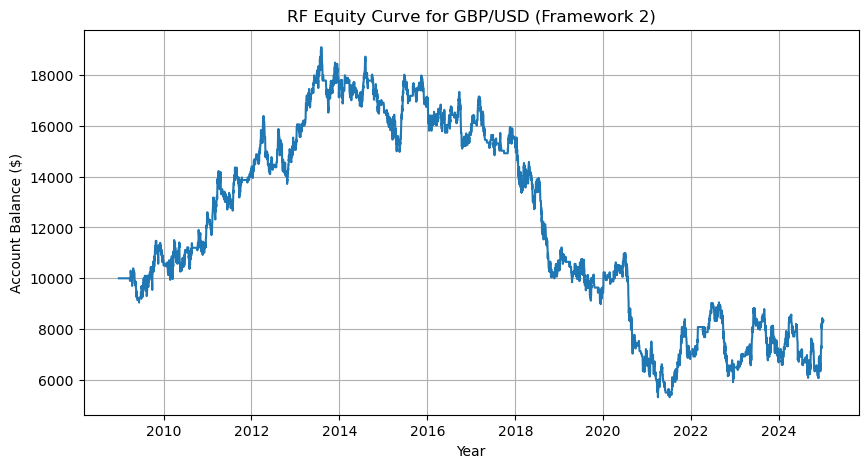

In [84]:
import matplotlib.dates as mdates

# --- Create a trading DataFrame for RF ---
rf_trading_df = data[["Gmt time", "Open", "High", "Low", "Close", "Day", "ATR"]].copy()
rf_preds = rf_predictions_full[['Gmt time', 'Label_pred']].rename(columns={'Label_pred': 'RF_pred'})
rf_trading_df = pd.merge(rf_trading_df, rf_preds, on="Gmt time", how="left")

# --- Compute SL and TP based on RF predictions ---
def compute_sl_tp_rf(row):
    sl_coef = 1.5
    tp_coef = 3.0
    if row['RF_pred'] == 2:  # Long trade
        sl = row['Close'] - sl_coef * row['ATR']
        tp = row['Close'] + tp_coef * row['ATR']
    elif row['RF_pred'] == 1:  # Short trade
        sl = row['Close'] + sl_coef * row['ATR']
        tp = row['Close'] - tp_coef * row['ATR']
    else:
        sl, tp = np.nan, np.nan
    return pd.Series([sl, tp])

rf_trading_df[['SL', 'TP']] = rf_trading_df.apply(compute_sl_tp_rf, axis=1)

# --- Backtesting Function (nur ein Trade zur Zeit) ---
def backtest_trades(df, prediction_col, initial_balance=10000, risk_percent=0.01, max_horizon=24):
    balance = initial_balance
    equity_curve = [balance]
    equity_dates = [df.loc[0, 'Gmt time']]
    trades = []
    i = 0
    while i < len(df):
        signal = df.loc[i, prediction_col]
        if signal in [1, 2]:
            entry_price = df.loc[i, 'Close']
            entry_date = df.loc[i, 'Gmt time']
            # Fester Risikobetrag: 1% der ursprünglichen Balance (z.B. 100 USD)
            risk = initial_balance * risk_percent
            risk_per_unit = abs(entry_price - df.loc[i, 'SL'])
            position_size = risk / risk_per_unit if risk_per_unit != 0 else 0
            exit_price = None; exit_index = None; closed = False
            for j in range(i+1, min(i+1+max_horizon, len(df))):
                if signal == 2:  # Long trade
                    if df.loc[j, 'Low'] <= df.loc[i, 'SL']:
                        exit_price, exit_index, closed = df.loc[i, 'SL'], j, True; break
                    if df.loc[j, 'High'] >= df.loc[i, 'TP']:
                        exit_price, exit_index, closed = df.loc[i, 'TP'], j, True; break
                elif signal == 1:  # Short trade
                    if df.loc[j, 'High'] >= df.loc[i, 'SL']:
                        exit_price, exit_index, closed = df.loc[i, 'SL'], j, True; break
                    if df.loc[j, 'Low'] <= df.loc[i, 'TP']:
                        exit_price, exit_index, closed = df.loc[i, 'TP'], j, True; break
            if not closed:
                j = min(i+max_horizon, len(df)-1)
                exit_price, exit_index = df.loc[j, 'Close'], j
            exit_date = df.loc[exit_index, 'Gmt time']
            profit = (exit_price - entry_price) * position_size if signal == 2 else (entry_price - exit_price) * position_size
            balance += profit
            equity_curve.append(balance)
            equity_dates.append(exit_date)
            trades.append({
                'entry_index': i,
                'exit_index': exit_index,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'signal': signal,
                'position_size': position_size,
                'profit': profit,
                'balance': balance,
                'entry_date': entry_date,
                'exit_date': exit_date
            })
            i = exit_index + 1
        else:
            equity_curve.append(balance)
            equity_dates.append(df.loc[i, 'Gmt time'])
            i += 1
    return pd.DataFrame(trades), equity_curve, equity_dates

# --- Detailed Metrics Calculation (inklusive zusätzlicher Kennzahlen) ---
def compute_detailed_metrics(trades_df, equity_curve, equity_dates, initial_balance=10000):
    if trades_df.empty:
        return {}
    
    final_balance = trades_df.iloc[-1]['balance']
    total_return_pct = (final_balance / initial_balance - 1) * 100
    # Handelszeitraum (nach entry_date)
    start_year = trades_df.iloc[0]['entry_date'].year
    end_year = trades_df.iloc[-1]['exit_date'].year
    num_years = end_year - start_year + 1
    avg_return_year = total_return_pct / num_years
    
    # Long- und Short-Trades
    long_trades = trades_df[trades_df['signal'] == 2]
    short_trades = trades_df[trades_df['signal'] == 1]
    long_win_pct = (len(long_trades[long_trades['profit'] > 0]) / len(long_trades) * 100) if len(long_trades) > 0 else np.nan
    short_win_pct = (len(short_trades[short_trades['profit'] > 0]) / len(short_trades) * 100) if len(short_trades) > 0 else np.nan
    
    # Jahresreturns: Summe der Profite pro Jahr als % der ursprünglichen Balance
    trades_df['entry_year'] = trades_df['entry_date'].dt.year
    year_returns = trades_df.groupby('entry_year')['profit'].sum() / initial_balance * 100
    
    # Durchschnittlicher Monatsreturn: Durchschnittlicher Profit % pro Trade, gruppiert nach entry_month
    trades_df['entry_month'] = trades_df['entry_date'].dt.month
    month_returns = trades_df.groupby('entry_month')['profit'].mean() / initial_balance * 100
    
    win_rate = len(trades_df[trades_df['profit'] > 0]) / len(trades_df) if len(trades_df) > 0 else 0
    
    # Absoluter Total Return (in USD)
    total_return_abs = final_balance - initial_balance
    
    # Prüfe, ob und wann der Kontostand 0 oder darunter fällt
    date_account_reached_zero = None
    for eq, dt in zip(equity_curve, equity_dates):
        if eq <= 0:
            date_account_reached_zero = dt.strftime("%Y-%m-%d")
            break
    if date_account_reached_zero is None:
        date_account_reached_zero = "Never"
    
    detailed = {
        'Total Return (%)': total_return_pct,
        'Avg Return per Year (%)': avg_return_year,
        'Number of Trades': len(trades_df),
        'Long Trades': len(long_trades),
        'Long Win Percentage (%)': long_win_pct,
        'Short Trades': len(short_trades),
        'Short Win Percentage (%)': short_win_pct,
        'Yearly Returns (%)': year_returns.to_dict(),
        'Avg Return per Month (%)': month_returns.to_dict(),
        'Total Return': total_return_abs,
        'Win Rate': win_rate,
        'Date Account Reached 0': date_account_reached_zero
    }
    return detailed

# --- Run the RF Backtest ---
rf_trades, rf_equity, rf_equity_dates = backtest_trades(rf_trading_df, prediction_col='RF_pred')

# --- Compute and print the metrics ---
rf_detailed_metrics = compute_detailed_metrics(rf_trades, rf_equity, rf_equity_dates, initial_balance=10000)
print("RF Detailed Metrics:")
for key, value in rf_detailed_metrics.items():
    print(f"{key}: {value}")

# --- Plot Equity Curve with Yearly X-axis ---
rf_equity_df = pd.DataFrame({'Date': rf_equity_dates, 'Equity': rf_equity})
rf_equity_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 5))
plt.plot(rf_equity_dates, rf_equity, label="RF Equity Curve (Framework 2)")
plt.xlabel("Year")
plt.ylabel("Account Balance ($)")
plt.title("RF Equity Curve for GBP/USD (Framework 2)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.show()


## Random Forest: Framework 1  

Backtesting Metrics:
Total Return (%): -563.670253779946
Avg Return per Year (%): -35.22939086124663
Number of Trades: 39905
Long Trades: 16508
Long Win Percentage (%): 35.4010176883935
Short Trades: 23397
Short Win Percentage (%): 35.12416121725008
Yearly Returns (%): {2009: 159.3641016039365, 2010: 280.41238974171637, 2011: 127.21143959884247, 2012: 240.84279582058318, 2013: -6.637349556213018, 2014: -34.978886260471, 2015: -152.92494647923579, 2016: -336.49699859853814, 2017: 25.243127979987108, 2018: -277.91039749970247, 2019: -118.9101815294765, 2020: -276.0595014057952, 2021: -129.8630368375983, 2022: -135.80040891478276, 2023: 110.13364007186372, 2024: -37.296041515057595}
Avg Return per Month (%): {1: 0.07857478097790038, 2: -0.017439766461117643, 3: 0.13880202976447542, 4: -0.09125891150114931, 5: -0.07391235088201564, 6: 0.029459658169845016, 7: 0.018962057590912313, 8: -0.01674087675359102, 9: -0.09909960163626533, 10: 0.00591678687046087, 11: -0.08128881951726499, 12: 0.002

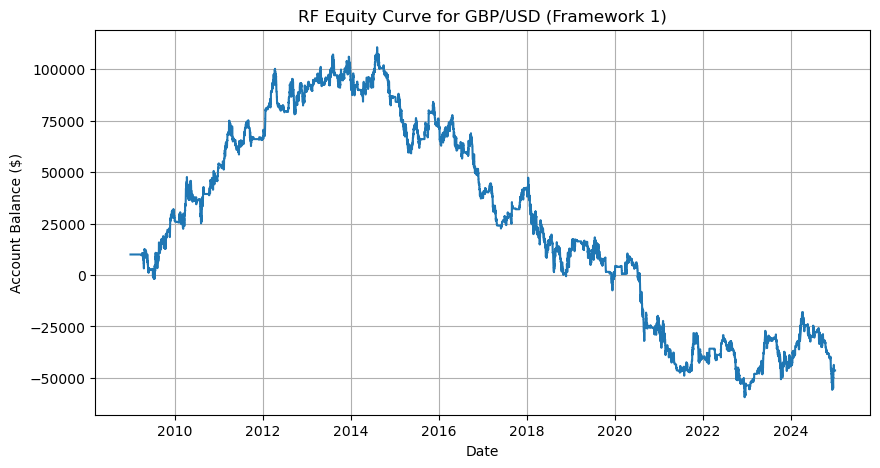

In [85]:
import matplotlib.dates as mdates

def backtest_trades_all_signals(df, prediction_col, initial_balance=10000, 
                                risk_percent=0.01, max_horizon=24):
    """
    Backtest-Funktion, die JEDES Signal handelt, ohne auf das Schließen
    laufender Positionen zu warten.
    """
    balance = initial_balance
    equity_curve = []
    equity_dates = []

    # Hier kommen alle abgeschlossenen Trades hinein
    closed_trades = []
    # Hier verwalten wir alle aktuell offenen Trades
    open_trades = []

    for i in range(len(df)):
        current_time = df.loc[i, 'Gmt time']
        current_close = df.loc[i, 'Close']
        
        # --- 1) Neues Signal an diesem Datenpunkt? ---
        signal = df.loc[i, prediction_col]
        if signal in [1, 2]:
            # Long = 2, Short = 1
            entry_price = current_close
            sl = df.loc[i, 'SL']
            tp = df.loc[i, 'TP']
            
            # Positionsgröße berechnen
            risk = initial_balance * risk_percent
            risk_per_unit = abs(entry_price - sl)
            position_size = risk / risk_per_unit if risk_per_unit != 0 else 0

            new_trade = {
                'entry_index': i,
                'entry_date': current_time,
                'entry_price': entry_price,
                'SL': sl,
                'TP': tp,
                'signal': signal,          # 2 = Long, 1 = Short
                'position_size': position_size,
                'balance_before': balance  # Aktueller Kontostand zum Zeitpunkt des Einstiegs
            }
            open_trades.append(new_trade)

        # --- 2) Offene Trades prüfen und ggf. schließen ---
        trades_to_close = []
        for ot in open_trades:
            # Anzahl Bars, die der Trade bereits offen ist
            bars_held = i - ot['entry_index']
            # Falls max. Haltezeit überschritten -> zum aktuellen Kurs schließen
            if bars_held > max_horizon:
                exit_price = current_close
                profit = (exit_price - ot['entry_price']) * ot['position_size'] \
                         if ot['signal'] == 2 else \
                         (ot['entry_price'] - exit_price) * ot['position_size']
                balance += profit
                trades_to_close.append((ot, exit_price, profit, i, current_time))
            else:
                # SL/TP-Check mit den High/Low-Werten der aktuellen Kerze
                if ot['signal'] == 2:  # Long
                    if df.loc[i, 'Low'] <= ot['SL']:
                        exit_price = ot['SL']
                        profit = (exit_price - ot['entry_price']) * ot['position_size']
                        balance += profit
                        trades_to_close.append((ot, exit_price, profit, i, current_time))
                    elif df.loc[i, 'High'] >= ot['TP']:
                        exit_price = ot['TP']
                        profit = (exit_price - ot['entry_price']) * ot['position_size']
                        balance += profit
                        trades_to_close.append((ot, exit_price, profit, i, current_time))
                else:  # Short = 1
                    if df.loc[i, 'High'] >= ot['SL']:
                        exit_price = ot['SL']
                        profit = (ot['entry_price'] - exit_price) * ot['position_size']
                        balance += profit
                        trades_to_close.append((ot, exit_price, profit, i, current_time))
                    elif df.loc[i, 'Low'] <= ot['TP']:
                        exit_price = ot['TP']
                        profit = (ot['entry_price'] - exit_price) * ot['position_size']
                        balance += profit
                        trades_to_close.append((ot, exit_price, profit, i, current_time))

        # Geschlossene Trades aus der Liste entfernen und ins closed_trades-DF packen
        for ot_close in trades_to_close:
            ot, exit_price, profit, exit_idx, exit_time = ot_close
            open_trades.remove(ot)
            closed_trades.append({
                'entry_index': ot['entry_index'],
                'exit_index': exit_idx,
                'entry_price': ot['entry_price'],
                'exit_price': exit_price,
                'signal': ot['signal'],
                'position_size': ot['position_size'],
                'profit': profit,
                'balance': balance,
                'entry_date': ot['entry_date'],
                'exit_date': exit_time
            })

        # --- 3) Equity-Tracking (aktueller Kontostand) ---
        equity_curve.append(balance)
        equity_dates.append(current_time)

    # --- 4) Falls nach Ende noch Trades offen sind, am letzten Kurs schließen ---
    if len(open_trades) > 0:
        final_idx = len(df) - 1
        final_close = df.loc[final_idx, 'Close']
        final_time = df.loc[final_idx, 'Gmt time']
        for ot in open_trades:
            exit_price = final_close
            profit = (exit_price - ot['entry_price']) * ot['position_size'] \
                     if ot['signal'] == 2 else \
                     (ot['entry_price'] - exit_price) * ot['position_size']
            balance += profit
            closed_trades.append({
                'entry_index': ot['entry_index'],
                'exit_index': final_idx,
                'entry_price': ot['entry_price'],
                'exit_price': exit_price,
                'signal': ot['signal'],
                'position_size': ot['position_size'],
                'profit': profit,
                'balance': balance,
                'entry_date': ot['entry_date'],
                'exit_date': final_time
            })
        open_trades = []
        equity_curve[-1] = balance

    trades_df = pd.DataFrame(closed_trades)
    return trades_df, equity_curve, equity_dates

def compute_detailed_metrics_all_signals(trades_df, equity_curve, equity_dates, initial_balance=10000):
    """
    Berechnet diverse Backtesting-Metriken:
      - Total Return (%)
      - Average Return per Year (%)
      - Anzahl Trades
      - Anzahl Long Trades
      - Long Win Percentage (%)
      - Anzahl Short Trades
      - Short Win Percentage (%)
      - Yearly Returns (%)
      - Average Return per Month (%)
      - Total Return (absolut)
      - Win Rate
      - Date Account Reached 0 (falls es passiert)
    """
    if trades_df.empty:
        return {}

    final_balance = equity_curve[-1]
    total_return_pct = (final_balance / initial_balance - 1) * 100
    
    # Bestimme den Handelszeitraum anhand des ersten Einstiegs- und letzten Ausstiegsdatums
    start_year = trades_df.iloc[0]['entry_date'].year
    end_year = trades_df.iloc[-1]['exit_date'].year
    num_years = end_year - start_year + 1
    avg_return_year = total_return_pct / num_years

    # Separiere Long und Short Trades
    long_trades = trades_df[trades_df['signal'] == 2]
    short_trades = trades_df[trades_df['signal'] == 1]
    long_win_pct = (len(long_trades[long_trades['profit'] > 0]) / len(long_trades) * 100) if len(long_trades) > 0 else np.nan
    short_win_pct = (len(short_trades[short_trades['profit'] > 0]) / len(short_trades) * 100) if len(short_trades) > 0 else np.nan

    # Gruppierung nach Jahr für Jahresreturns
    trades_df['entry_year'] = trades_df['entry_date'].dt.year
    year_returns = trades_df.groupby('entry_year')['profit'].sum() / initial_balance * 100

    # Gruppierung nach Monat für durchschnittliche Monatsreturns
    trades_df['entry_month'] = trades_df['entry_date'].dt.month
    month_returns = trades_df.groupby('entry_month')['profit'].mean() / initial_balance * 100

    win_rate = len(trades_df[trades_df['profit'] > 0]) / len(trades_df) if len(trades_df) > 0 else 0

# Prüfe, ob und wann der Kontostand 0 oder darunter fällt
    date_account_reached_zero = None
    for eq, dt in zip(equity_curve, equity_dates):
        if eq <= 0:
            date_account_reached_zero = dt.strftime("%Y-%m-%d")
            break
    if date_account_reached_zero is None:
        date_account_reached_zero = "Never"

    metrics = {
        'Total Return (%)': total_return_pct,
        'Avg Return per Year (%)': avg_return_year,
        'Number of Trades': len(trades_df),
        'Long Trades': len(long_trades),
        'Long Win Percentage (%)': long_win_pct,
        'Short Trades': len(short_trades),
        'Short Win Percentage (%)': short_win_pct,
        'Yearly Returns (%)': year_returns.to_dict(),
        'Avg Return per Month (%)': month_returns.to_dict(),
        'Total Return': final_balance - initial_balance,
        'Win Rate': win_rate,
        'Date Account Reached 0': date_account_reached_zero 
    }
    return metrics

# -------------------------------------
# Beispiel-Aufruf
# -------------------------------------
# Angenommen, dein DataFrame heißt rf_trading_df
# und die Spalte mit den Signalen heißt 'RF_pred' 
rf_trades_all, rf_equity_all, rf_equity_dates_all = backtest_trades_all_signals(
     df=rf_trading_df,
     prediction_col='RF_pred',
     initial_balance=10000,
     risk_percent=0.01,
     max_horizon=24
)

# Berechne die Metriken
metrics = compute_detailed_metrics_all_signals(rf_trades_all, rf_equity_all, rf_equity_dates_all, initial_balance=10000)

print("Backtesting Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")

# Plot Equity Curve
plt.figure(figsize=(10, 5))
plt.plot(rf_equity_dates_all, rf_equity_all, label="RF Equity Curve (Framework 1)")
plt.xlabel("Date")
plt.ylabel("Account Balance ($)")
plt.title("RF Equity Curve for GBP/USD (Framework 1)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.show()


## MLP: Framework 1

MLP Detailed Metrics (All Signals Executed):
Total Return (%): -960.058474090594
Avg Return per Year (%): -60.003654630662126
Number of Trades: 58044
Long Trades: 27471
Long Win Percentage (%): 35.502893960904224
Short Trades: 30573
Short Win Percentage (%): 35.09305596441305
Yearly Returns (%): {2009: -98.54206725328099, 2010: 223.63555157575937, 2011: -90.19948119602205, 2012: 38.42721592224317, 2013: 151.95161097446314, 2014: -261.3345945020396, 2015: -243.3115709553507, 2016: -511.12889670564215, 2017: 14.09941812227501, 2018: -96.92374238099714, 2019: 166.03371307475268, 2020: 23.805230471775012, 2021: -244.1659124773112, 2022: -160.251000059358, 2023: -29.993623028243192, 2024: 157.83967432638153}
Avg Return per Month (%): {1: 0.04726117103053499, 2: -0.05166714008888923, 3: 0.0037830974678447296, 4: -0.06862940998788103, 5: -0.061793786131739636, 6: -0.0011099484916631793, 7: 0.03299781282598598, 8: -0.029538918828178336, 9: -0.08274431894836094, 10: 0.06111537101176365, 11: -0.

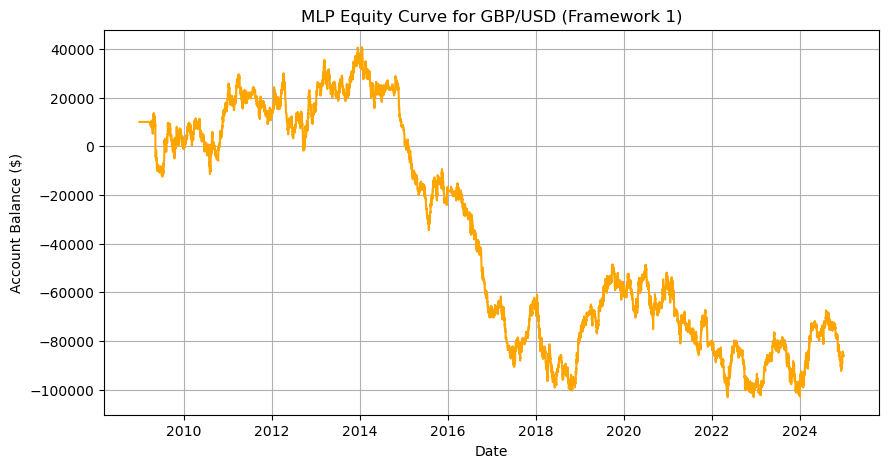

In [91]:
import matplotlib.dates as mdates

# --- Create Trading DataFrame for MLP ---
mlp_trading_df = data[["Gmt time", "Open", "High", "Low", "Close", "Day", "ATR"]].copy()
# Assume mlp_predictions_full contains columns: "Gmt time" and "Label_pred" from the MLP rolling-window predictions.
mlp_predictions = mlp_predictions_full[['Gmt time', 'Label_pred']].rename(columns={'Label_pred': 'MLP_pred'})
mlp_trading_df = pd.merge(mlp_trading_df, mlp_predictions, on="Gmt time", how="left")

# --- Compute SL and TP for MLP based on predicted label ---
def compute_sl_tp_mlp(row):
    sl_coef = 1.5
    tp_coef = 3.0
    if row['MLP_pred'] == 2:  # Long trade
        sl = row['Close'] - sl_coef * row['ATR']
        tp = row['Close'] + tp_coef * row['ATR']
    elif row['MLP_pred'] == 1:  # Short trade
        sl = row['Close'] + sl_coef * row['ATR']
        tp = row['Close'] - tp_coef * row['ATR']
    else:
        sl, tp = np.nan, np.nan
    return pd.Series([sl, tp])

mlp_trading_df[['SL', 'TP']] = mlp_trading_df.apply(compute_sl_tp_mlp, axis=1)

# --- Run the "all signals executed" backtest for MLP predictions ---
mlp_trades_all, mlp_equity_all, mlp_equity_dates_all = backtest_trades_all_signals(
    df=mlp_trading_df,
    prediction_col='MLP_pred',
    initial_balance=10000,
    risk_percent=0.01,
    max_horizon=24
)

# --- Compute detailed metrics for the MLP backtest (all signals executed) ---
mlp_detailed_metrics = compute_detailed_metrics_all_signals(
    mlp_trades_all, mlp_equity_all, mlp_equity_dates_all, initial_balance=10000
)

print("MLP Detailed Metrics (All Signals Executed):")
for key, value in mlp_detailed_metrics.items():
    print(f"{key}: {value}")

# --- Plot Equity Curve ---
plt.figure(figsize=(10, 5))
plt.plot(mlp_equity_dates_all, mlp_equity_all, label="MLP Equity Curve (All Signals Executed)", color='orange')
plt.xlabel("Date")
plt.ylabel("Account Balance ($)")
plt.title("MLP Equity Curve for GBP/USD (Framework 1)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.show()


## MLP: Framework 2

MLP Detailed Metrics:
Total Return (%): 32.72626911613503
Avg Return per Year (%): 2.0453918197584393
Number of Trades: 6546
Long Trades: 3155
Long Win Percentage (%): 37.210776545166404
Short Trades: 3391
Short Win Percentage (%): 36.41993512238278
Yearly Returns (%): {2009: 16.011691119582686, 2010: 2.0431625906539375, 2011: -29.98491978653946, 2012: -4.55662268668956, 2013: 41.72819290143248, 2014: 1.5146773627692787, 2015: -3.9968545033072, 2016: -30.173033123339955, 2017: 32.215035518070785, 2018: -21.56117771293657, 2019: 8.026489227465648, 2020: -24.49855661311868, 2021: -29.262621814972885, 2022: 6.943087582718217, 2023: 27.623743091008457, 2024: 40.65397596333787}
Avg Return per Month (%): {1: 0.07781151631444698, 2: -0.09138111962264842, 3: 0.04972536634802298, 4: -0.0684438316410727, 5: -0.01578088982614678, 6: 0.07601787782584936, 7: -0.0023422859140212263, 8: -0.05160365956296541, 9: -0.04829038095545124, 10: 0.11600743700978379, 11: -0.04738397061691448, 12: 0.07358564267

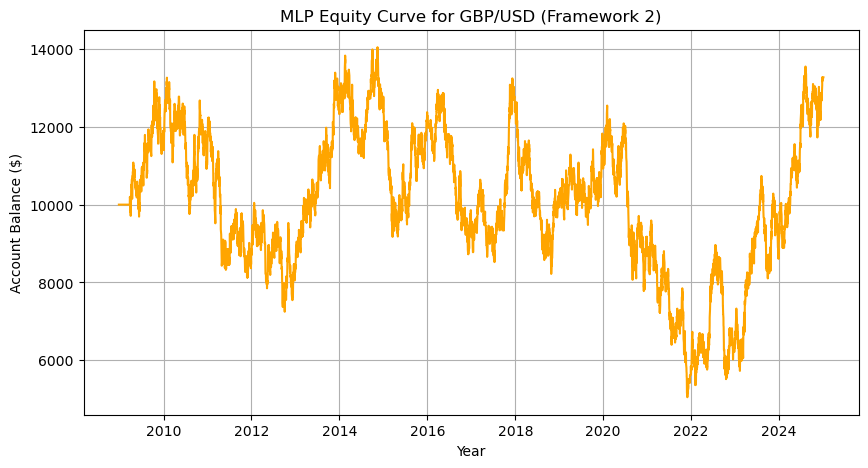

In [87]:
import matplotlib.dates as mdates

# --- Create Trading DataFrame for MLP ---
mlp_trading_df = data[["Gmt time", "Open", "High", "Low", "Close", "Day", "ATR"]].copy()
# Assume mlp_predictions_full contains columns: "Gmt time" and "Label_pred" from the MLP rolling-window predictions.
mlp_predictions = mlp_predictions_full[['Gmt time', 'Label_pred']].rename(columns={'Label_pred': 'MLP_pred'})
mlp_trading_df = pd.merge(mlp_trading_df, mlp_predictions, on="Gmt time", how="left")

# --- Compute SL and TP for MLP based on predicted label ---
def compute_sl_tp_mlp(row):
    sl_coef = 1.5
    tp_coef = 3.0
    if row['MLP_pred'] == 2:  # Long trade
        sl = row['Close'] - sl_coef * row['ATR']
        tp = row['Close'] + tp_coef * row['ATR']
    elif row['MLP_pred'] == 1:  # Short trade
        sl = row['Close'] + sl_coef * row['ATR']
        tp = row['Close'] - tp_coef * row['ATR']
    else:
        sl, tp = np.nan, np.nan
    return pd.Series([sl, tp])

mlp_trading_df[['SL', 'TP']] = mlp_trading_df.apply(compute_sl_tp_mlp, axis=1)

# --- Use the same backtesting function (only one trade at a time) ---
mlp_trades, mlp_equity, mlp_equity_dates = backtest_trades(mlp_trading_df, prediction_col='MLP_pred')

# --- Compute detailed metrics (using the same function as for RF) ---
mlp_detailed_metrics = compute_detailed_metrics(mlp_trades, mlp_equity, mlp_equity_dates, initial_balance=10000)

print("MLP Detailed Metrics:")
for key, value in mlp_detailed_metrics.items():
    print(f"{key}: {value}")

# --- Plot Equity Curve with Yearly X-axis ---
mlp_equity_df = pd.DataFrame({'Date': mlp_equity_dates, 'Equity': mlp_equity})
mlp_equity_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 5))
plt.plot(mlp_equity_dates, mlp_equity, label="MLP Equity Curve", color='orange')
plt.xlabel("Year")
plt.ylabel("Account Balance ($)")
plt.title("MLP Equity Curve for GBP/USD (Framework 2)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.show()
